# Feature Engineering 

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.feature_extraction import FeatureHasher
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
# ==============================
df = pd.read_csv("C:/Users/tehre/OneDrive/Desktop/KaggleV2-May-2016.csv")

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# 2. Continuous Data Feature Engineering

# Fix column names (remove spaces and standardize)
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={'No_show': 'No-show', 'no-show': 'No-show', 'No Show': 'No-show'}, inplace=True)

# Convert date columns
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Ensure 'No-show' column exists
if 'No-show' not in df.columns:
    print("❌ Critical Error: 'No-show' column does NOT exist! Exiting.")
    exit()

# Convert 'No-show' to binary (Yes → 1, No → 0)
df['No-show'] = df['No-show'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})

# Fill NaN values in 'No-show' if any
if df['No-show'].isna().sum() > 0:
    df['No-show'].fillna(df['No-show'].mode()[0], inplace=True)

print("✅ Final 'No-show' Value Counts:\n", df['No-show'].value_counts())

# ======================================
#  3. Continuous Feature Engineering
# ======================================

# Compute Wait Time (Ensure No Negative Values)
df['WaitTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['WaitTime'] = df['WaitTime'].clip(lower=0).fillna(0)

# Log transformation (Handle log errors)
df['WaitTime_Log'] = np.log1p(df['WaitTime'])

# Standardization & Normalization
scaler_std = StandardScaler()
df['WaitTime_Std'] = scaler_std.fit_transform(df[['WaitTime_Log']])

scaler_minmax = MinMaxScaler()
df['WaitTime_MinMax'] = scaler_minmax.fit_transform(df[['WaitTime_Log']])


✅ Final 'No-show' Value Counts:
 No-show
0    88208
1    22319
Name: count, dtype: int64


In [56]:

# 4. Feature Interactions & Polynomial Features
# ======================================

# Feature Interactions (Ensure NaN handling)
df['WaitTime_Age_Interaction'] = df['WaitTime'] * df['Age'].fillna(df['Age'].median())

# Polynomial Features (Ensure Proper Handling of NaN)
poly = PolynomialFeatures(degree=2, interaction_only=True)
df[['Age', 'WaitTime']] = df[['Age', 'WaitTime']].fillna(df[['Age', 'WaitTime']].median())
poly_features = poly.fit_transform(df[['Age', 'WaitTime']])

df_poly = pd.DataFrame(poly_features, columns=[f'poly_{i}' for i in range(poly_features.shape[1])])
df_poly.index = df.index  # Ensure index alignment
df = pd.concat([df, df_poly], axis=1)



In [57]:

# 5. Date & Time Feature Engineering


df['AppointmentDay_Day'] = df['AppointmentDay'].dt.day
df['AppointmentDay_Month'] = df['AppointmentDay'].dt.month
df['AppointmentDay_Weekday'] = df['AppointmentDay'].dt.dayofweek

# Time-Series Features (Handle NaN)
df['WaitTime_RollingMean_3'] = df['WaitTime'].rolling(3, min_periods=1).mean()
df['WaitTime_Lag_1'] = df['WaitTime'].shift(1).fillna(df['WaitTime'].median())


In [58]:

#  6. Categorical Data Feature Engineering


# 1️ Fix Column Names (Remove Spaces)
df.rename(columns=lambda x: x.strip(), inplace=True)

# 2️ Ordinal Encoding for Gender
df['Gender_Encoded'] = df['Gender'].map({'F': 0, 'M': 1}).fillna(-1)

# 3️⃣ Handle 'Neighbourhood' Column
# If original column exists, apply one-hot encoding
if 'Neighbourhood' in df.columns:
    df['Neighbourhood'] = df['Neighbourhood'].astype(str)
    df = pd.get_dummies(df, columns=['Neighbourhood'], prefix='NB', drop_first=True)
    print("✅ One-hot encoding applied for 'Neighbourhood'.")

# If 'Neighbourhood' does NOT exist, check for pre-existing 'NB_' columns
elif any(col.startswith('NB_') for col in df.columns):
    print("✅ 'Neighbourhood' was already one-hot encoded. Skipping encoding step.")

# If neither 'Neighbourhood' nor 'NB_' columns exist, raise a warning
else:
    print("❌ Critical Error: 'Neighbourhood' column is missing entirely. Check dataset!")

# 4️ Feature Hashing
df['DummyText'] = df.index.astype(str)
hasher = FeatureHasher(n_features=8, input_type='string')

# Ensure each sample is a list (iterable of iterables)
hashed_features = hasher.transform(df['DummyText'].apply(lambda x: [x])).toarray()

df_hashed = pd.DataFrame(hashed_features, columns=[f'hashed_{i}' for i in range(8)])
df_hashed.index = df.index  # Ensure index alignment
df = pd.concat([df, df_hashed], axis=1)

# Drop the DummyText column after hashing
df.drop(columns=['DummyText'], inplace=True)


✅ One-hot encoding applied for 'Neighbourhood'.


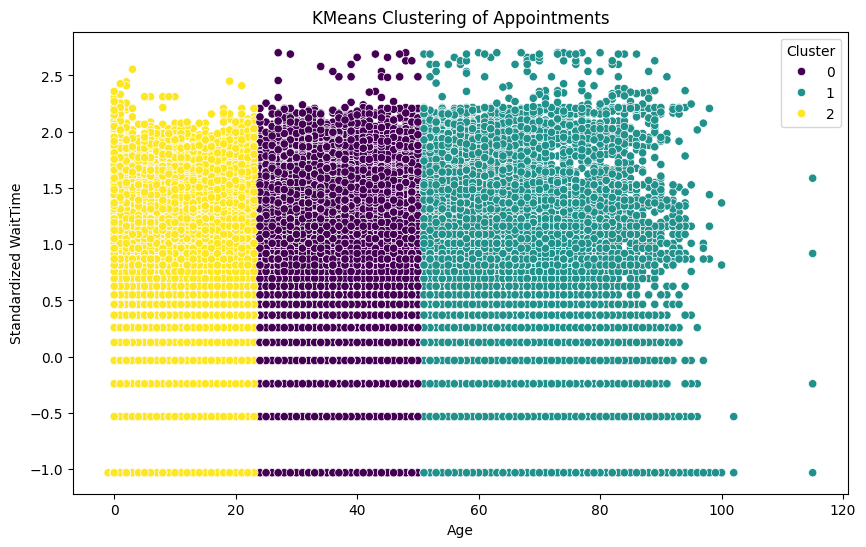

In [59]:

#  7. Clustering (For Outlier Detection)
# ======================================
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Verify column existence
if 'Age' not in df.columns or 'WaitTime_Std' not in df.columns:
    print("❌ Error: Required columns missing for clustering visualization!")
    print("Available columns:", df.columns.tolist())
else:
    # Convert columns to numeric 
    df[['Age', 'WaitTime_Std']] = df[['Age', 'WaitTime_Std']].apply(pd.to_numeric, errors='coerce')

    # Drop NaN values before clustering
    df.dropna(subset=['Age', 'WaitTime_Std'], inplace=True)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[['Age', 'WaitTime_Std']])

    #  Plot clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Age', y='WaitTime_Std', hue=df['Cluster'], palette='viridis', data=df)
    plt.title('KMeans Clustering of Appointments')
    plt.xlabel('Age')
    plt.ylabel('Standardized WaitTime')
    plt.legend(title="Cluster")
    plt.show()



In [60]:

# 8. Handling Imbalanced Data (SMOTE)
# ======================================

# Identify One-Hot Encoded Neighbourhood Features
neighbourhood_features = [col for col in df.columns if col.startswith("NB_")]

# Select Features for SMOTE
features_for_model = ['Age', 'WaitTime_Std'] + neighbourhood_features

# Ensure 'ChronicCount' exists before selecting features
if 'ChronicCount' in df.columns:
    features_for_model.append('ChronicCount')

# Select valid columns only
features_for_model = [col for col in features_for_model if col in df.columns]

# Define X (features) and y (target)
X = df[features_for_model]
y = df['No-show']

print("Before SMOTE:\n", y.value_counts())

# Apply SMOTE only if `y` has at least 2 unique values
if len(y.unique()) > 1:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("After SMOTE:\n", pd.Series(y_resampled).value_counts())
else:
    print("⚠️ Skipping SMOTE: Only one class detected in `y`.")


Before SMOTE:
 No-show
0    88208
1    22319
Name: count, dtype: int64
After SMOTE:
 No-show
0    88208
1    88208
Name: count, dtype: int64


In [61]:

# ======================================
# 9. Save Processed Data
# ======================================
df.to_csv("processed_noshowappointments.csv", index=False)
print("Feature engineering completed successfully! 🎉")

Feature engineering completed successfully! 🎉
